In [1]:
!pip install elasticsearch==7.12.0
!pip install arrow

In [20]:
!pip install nltk
!pip install seaborn
!pip install wordcloud

     |████████████████████████████████| 1.5 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 47.0 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 933 kB/s  eta 0:00:01
     |████████████████████████████████| 771 kB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 293 kB 5.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.2 MB 51.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 40.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 84.0 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 57.1 MB/s eta 0:00:01
     |████████████████████████████████| 458 kB 5.5 MB/s eta 0:00:01


In [1]:
import os, arrow
from elasticsearch import Elasticsearch
from datetime import datetime
from config import SOC_ES_HOST,SOC_ES_USER, SOC_ES_PASSWORD, SOC_ES_PORT

import requests
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import nltk

In [40]:
es = Elasticsearch([SOC_ES_HOST], http_auth=(SOC_ES_USER, SOC_ES_PASSWORD), port=SOC_ES_PORT, timeout=60)


In [5]:
res = es.search(index="streamfr", body={"query": {"match": { 
                'title':'covid',


            }
        }
    }
)
print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    #print("%(timestamp)s %(title)s: %(text)s" % hit["_source"])
    print(hit['_source'])

Got 10000 Hits:
{'edit_history_tweet_ids': [1634708775599845400], 'fixdate': '2023-03-12', 'fixhour': '2023-03-12-00', 'foundtime': 1678579918, 'text': '@POTUS Covid covid covid', 'author_id': 1560128340773769200, 'id': 1634708775599845400, 'annotation': '[{"domain": {"id": "10", "name": "Person", "description": "Named people in the world like Nelson Mandela"}, "entity": {"id": "10040395078", "name": "Joe Biden", "description": "US President Joe Biden"}}, {"domain": {"id": "35", "name": "Politician", "description": "Politicians in the world, like Joe Biden"}, "entity": {"id": "10040395078", "name": "Joe Biden", "description": "US President Joe Biden"}}, {"domain": {"id": "123", "name": "Ongoing News Story", "description": "Ongoing News Stories like \'Brexit\'"}, "entity": {"id": "1220701888179359745", "name": "COVID-19"}}, {"domain": {"id": "131", "name": "Unified Twitter Taxonomy", "description": "A taxonomy of user interests. "}, "entity": {"id": "10040395078", "name": "Joe Biden", "

In [41]:
def set_el_string(query:str) -> str:
     return "%s" %query.replace('|', 'OR')\
        .replace('/', '')\
        .replace('&', ' AND ')


index = 'streamfr'
query = 'title:Covid AND language:fr AND smitype:4'
data = []
doc = {"query": {"query_string": {"query": query, "default_operator": "AND"}},"size": 10000}



def get_news(index : str, keyword: dict , query=query, start = int(arrow.utcnow().shift(hours= -24).timestamp())
             ,end = int(arrow.utcnow().timestamp()),doc=doc):

    query = set_el_string(keyword['keywords']) + " AND timestamp:[{} TO {}]".format(start, end)
    print(query)
    if es.indices.exists(index=index):
            res = es.search(index = index,body= doc ,scroll="1m")

            while res['hits']['hits']:
                try:
                    sid = res['_scroll_id']
                    # get batch with data
                    scroll_res = res['hits']['hits']
                    data.extend(scroll_res)
                    # get next batch
                    res = es.scroll(scroll_id=sid, scroll="1m")
                except KeyError:
                    break
    else:
         return []
    return data


In [24]:
keywords = {}
keywords['keywords'] = 'covid' 
keywords = {'keywords': "id:100057438729357" }
data = get_news(query= query,keyword=keywords,index=index)

id:100057438729357 AND timestamp:[1681294344 TO 1681380744]


In [42]:
import pandas as pd


keywords = {}
keywords['keywords'] = 'covid' 
keywords = {'keywords': "id:100057438729357" }

dataset = []
df = pd.DataFrame()
for i in range(6,7):
    
    query = "title:Covid AND language:fr AND smitype:4 AND fixdate:\"2023-03-%s\"" % str(i) 
    data = get_news(query= query,keyword=keywords,index=index)
    
    for item in data:
        dataset.append(item['_source'])

tmp = pd.DataFrame.from_dict(dataset)
df = df.append(tmp)


id:100057438729357 AND timestamp:[1681295143 TO 1681381543]


/tmp/ipykernel_4643/3769281792.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp)


In [43]:
# Set the number of rows to work with
num_row = 2000
df = df.iloc[:num_row]


In [44]:
df.shape

(2000, 24)

In [46]:
# Tokenize and remove unwanted words.

def preprocess_text(text):
    nltk.download('punkt')
    nltk.download('stopwords')
    tokens = word_tokenize(text.lower())
    french_stopwords = set(stopwords.words('french'))

    # Updated after first experiment, ask Yves if there are any words here that he doesn't want to remove
    missed_stopword_list = ['a','plus','cas','cette','depuis','contre','ans','après','fait', 'selon', 'aussi', 'moins', 'comme', 'être',
                         'si', 'tout', 'millions', 'très', 'faire', 'encore','dont','où', 'entre', 'avoir','autre','autres', 'sans', 'suite', 'alors'
                         , 'chez', 'déjà', 'ainsi', 'peu' , 'leurs']

    
    french_stopwords.update(missed_stopword_list)
    unwanted_tokens = french_stopwords.union({"'", "’", "-", "»", "«"})
    filtered_tokens = [token for token in tokens if token not in unwanted_tokens and token.isalpha()]
    return filtered_tokens

def count_words(tokens):
    return Counter(tokens)


# to remove html tags
def extract_text(articles):
    ''' input: List of article
        returns:
            whole text without html tags
    '''
    text = ""
    for article in articles:
        soup = BeautifulSoup(article, 'html.parser')
        text += soup.get_text()
    return text

def extract_text_from_single_article(article):
    '''
    input : 
            Single article
    returns :  
            Text version of article without html tags
    '''
    soup = BeautifulSoup(article, 'html.parser')
    return soup.get_text()




In [47]:
df = df.dropna(subset=['text'])
df['cleaned_text'] = df['text'].apply(extract_text_from_single_article)
df['tokens'] = df['cleaned_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/zeki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zeki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to

In [30]:
def sort_word_counts(counted_words):
    return sorted(counted_words.items(), key=lambda x: x[1], reverse=True)


def combine_all_words_with_columns(row):
    all_words = row['sorted_counted_words']
    combined_data = []

    for word, count in all_words:
        if not pd.isna(row['domain']):
            combined_data.append((word, count, row['domain']))

    return combined_data



In [48]:
df['count'] = df['tokens'].apply(count_words)

In [49]:
df['sorted_counted_words'] = df['count'].apply(sort_word_counts)

In [50]:
df['combined_data'] = df.apply(combine_all_words_with_columns, axis=1)


In [51]:
all_combined_data = sum(df['combined_data'], start=[])


In [52]:
# Create a pivot table with words as rows and journals as columns, where the values represent the word counts

all_df = pd.DataFrame(all_combined_data, columns=['word', 'count', 'journal'])

pivot_table = all_df.pivot_table(values='count', index='word', columns='journal', aggfunc='sum', fill_value=0)

# Calculate the dot product of the pivot table with itself to obtain the knowledge matrix
knowledge_matrix = pivot_table.dot(pivot_table.T)

# Display the knowledge matrix
print(knowledge_matrix)


word          aah  aba  abadie  abaissé  abandon  abandonnait  abandonne  \
word                                                                       
aah             1    0       0        0        0            0          0   
aba             0    1       0        0        0            0          0   
abadie          0    0       9        0        3            0          0   
abaissé         0    0       0        3        2            0          0   
abandon         0    0       3        2      186            1          6   
...           ...  ...     ...      ...      ...          ...        ...   
𝐠𝐨𝐮𝐯𝐞𝐫𝐧𝐞𝐦𝐞𝐧𝐭    0    0       0        0        0            0          0   
𝐥               0    0       0        0        0            0          0   
𝐥𝐞              0    0       0        0        0            0          0   
𝐨𝐮𝐯𝐞𝐫𝐭𝐮𝐫𝐞       0    0       0        0        0            0          0   
𝐭𝐞𝐫𝐫𝐞𝐬𝐭𝐫𝐞𝐬      0    0       0        0        0            0          0   

word       

The output is a symmetric knowledge matrix where both rows and columns represent unique words found in the articles. The elements of this matrix indicate the strength of the connections between the words based on their presence in the same journal.

The value at the intersection of a row and a column (i.e., cell [i, j]) represents the sum of the products of word i's count and word j's count for each journal in which they both appear. This value reflects how frequently these two words co-occur in the same journal. A higher value means a stronger connection between the two words.

The diagonal elements of the matrix (i.e., cells [i, i] for each word i) represent the self-connection of the words. These values are equal to the sum of the squares of the counts of each word in the respective journals. The diagonal values indicate the overall frequency of each word across all journals.

Please note that this matrix does not take into account the date or language columns. It only considers the words' co-occurrence in the same journal. If you want to include more factors in the connection strength calculation, you would need to modify the approach accordingly.

## Version 1 with avoiding duplicates


In [60]:
import numpy as np

# Set diagonal elements to a very low value as it presents self connections
np.fill_diagonal(knowledge_matrix.values, -1)

# Identify the largest values in the matrix
# You can choose the top_n strongest connections, e.g., top 1000
top_n = 1000
largest_indices = np.unravel_index(np.argsort(knowledge_matrix.values.ravel())[-top_n:], knowledge_matrix.shape)

# Extract the corresponding word pairs for these largest values, avoiding duplicates
strongest_connections = []
for index in range(len(largest_indices[0])):
    word1 = knowledge_matrix.index[largest_indices[0][index]]
    word2 = knowledge_matrix.index[largest_indices[1][index]]
    if word1 < word2:
        connection_strength = knowledge_matrix.at[word1, word2]
        strongest_connections.append((word1, word2, connection_strength))

# Sort the strongest_connections list based on connection strength in descending order
sorted_strongest_connections = sorted(strongest_connections, key=lambda x: x[2], reverse=True)

# Display the strongest connections in descending order
print("Connection Strenght:")
for connection in sorted_strongest_connections:
    print(f"{connection[0]} - {connection[1]}: {connection[2]}")




Connection Strenght:
sanitaire - situation: 2381362
indicateurs - situation: 1360756
découvre - situation: 1338019
indicateurs - sanitaire: 1300512
lire - situation: 1279849
découvre - sanitaire: 1278587
ensemble - situation: 1257945
permettent - situation: 1255266
lire - sanitaire: 1228517
mars - situation: 1205761
ensemble - sanitaire: 1202487
permettent - sanitaire: 1199699
départements - situation: 1169045
mars - sanitaire: 1155765
départements - sanitaire: 1117052
situation - évolution: 1106765
régionquelle - situation: 1104948
sanitaire - évolution: 1057802
régionquelle - sanitaire: 1055808
février - situation: 984202
février - sanitaire: 942381
avril - situation: 879345
avril - sanitaire: 841859
lundi - situation: 750353
lot - situation: 735311
gard - situation: 735286
gers - situation: 735144
situation - tarn: 735116
lozère - situation: 735094
découvre - indicateurs: 733570
lundi - sanitaire: 719395
lot - sanitaire: 702590
gard - sanitaire: 702543
gers - sanitaire: 702432
sanit

## Version 2 without avoiding duplicates

In [61]:
""" import numpy as np

# Set diagonal elements to a very low value as it presents self connections
np.fill_diagonal(knowledge_matrix.values, -1)

# Identify the largest values in the matrix
# You can choose the top_n strongest connections, e.g., top 1000
top_n = 1000
largest_indices = np.unravel_index(np.argsort(knowledge_matrix.values.ravel())[-top_n:], knowledge_matrix.shape)

# Extract the corresponding word pairs for these largest values
strongest_connections = []
for index in range(len(largest_indices[0])):
    word1 = knowledge_matrix.index[largest_indices[0][index]]
    word2 = knowledge_matrix.index[largest_indices[1][index]]
    connection_strength = knowledge_matrix.at[word1, word2]
    strongest_connections.append((word1, word2, connection_strength))

# Sort the strongest_connections list based on connection strength in descending order
sorted_strongest_connections = sorted(strongest_connections, key=lambda x: x[2], reverse=True)

# Display the strongest connections in descending order
print("Connection Strenght:")
for connection in sorted_strongest_connections:
    print(f"{connection[0]} - {connection[1]}: {connection[2]}")

 """

Connection Strenght:
sanitaire - situation: 2381362
situation - sanitaire: 2381362
indicateurs - situation: 1360756
situation - indicateurs: 1360756
situation - découvre: 1338019
découvre - situation: 1338019
sanitaire - indicateurs: 1300512
indicateurs - sanitaire: 1300512
situation - lire: 1279849
lire - situation: 1279849
découvre - sanitaire: 1278587
sanitaire - découvre: 1278587
situation - ensemble: 1257945
ensemble - situation: 1257945
permettent - situation: 1255266
situation - permettent: 1255266
lire - sanitaire: 1228517
sanitaire - lire: 1228517
situation - mars: 1205761
mars - situation: 1205761
ensemble - sanitaire: 1202487
sanitaire - ensemble: 1202487
sanitaire - permettent: 1199699
permettent - sanitaire: 1199699
situation - départements: 1169045
départements - situation: 1169045
mars - sanitaire: 1155765
sanitaire - mars: 1155765
sanitaire - départements: 1117052
départements - sanitaire: 1117052
évolution - situation: 1106765
situation - évolution: 1106765
situation -

## Visualization of strong connections

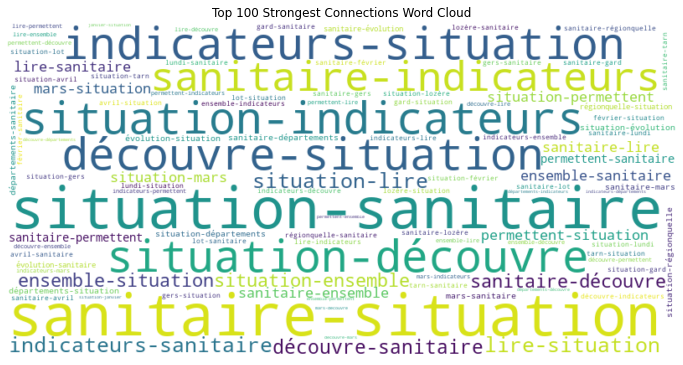

In [62]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(strongest_connections, title, n_keywords=100):
    top_n_connections = strongest_connections[:n_keywords]
    connection_strengths = {f"{conn[0]}-{conn[1]}": conn[2] for conn in top_n_connections}

    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(connection_strengths)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Plot the word cloud for the top 100 strongest connections
plot_word_cloud(sorted_strongest_connections, "Top 100 Strongest Connections Word Cloud", n_keywords=100)


### Visualization of connections without any replication of any word


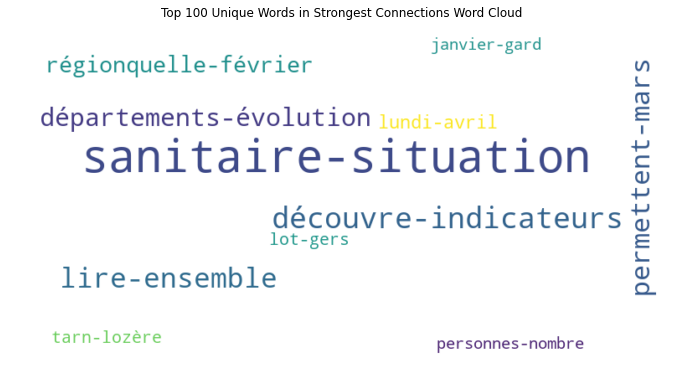

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(strongest_connections, title, n_keywords=150):
    top_n_connections = strongest_connections
    connection_strengths = {}
    included_words = set()
    
    for conn in top_n_connections:
        if len(included_words) >= n_keywords:
            break

        word1, word2 = conn[0], conn[1]
        if word1 not in included_words and word2 not in included_words:
            connection_strengths[f"{word1}-{word2}"] = conn[2]
            included_words.add(word1)
            included_words.add(word2)

    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(connection_strengths)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Plot the word cloud for the top 100 unique words in the strongest connections
plot_word_cloud(sorted_strongest_connections, "Top 100 Unique Words in Strongest Connections Word Cloud", n_keywords=100)


## Visualization of strong words (not connections)

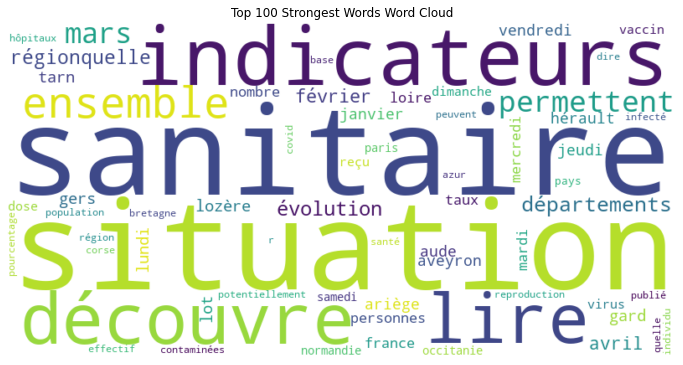

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(strongest_connections, title, n_keywords=100):
    top_n_connections = strongest_connections
    word_strengths = {}
    included_words = set()
    
    for conn in top_n_connections:
        word1, word2, strength = conn
        if word1 not in included_words:
            word_strengths[word1] = strength
            included_words.add(word1)
        if word2 not in included_words:
            word_strengths[word2] = strength
            included_words.add(word2)

        if len(included_words) >= n_keywords:
            break

    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_strengths)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Plot the word cloud for the top 100 strongest words
plot_word_cloud(sorted_strongest_connections, "Top 100 Strongest Words Word Cloud", n_keywords=100)


## Get connections of a specific word

In [59]:
def get_connections_of_word(word, knowledge_matrix):
    if word not in knowledge_matrix.index:
        print(f"{word} not found in the knowledge matrix.")
        return

    connections = knowledge_matrix.loc[word]
    sorted_connections = connections.sort_values(ascending=False)
    word_connections = [(word, conn_word, strength) for conn_word, strength in sorted_connections.items() if strength > 0]

    return word_connections

# Example
word = 'personnes'

# Get the connections for the specified word
word_connections = get_connections_of_word(word, knowledge_matrix)

# Display the connections
if word_connections:
    print(f"Connections of the word'{word}':")
    for connection in word_connections:
        print(f"{connection[0]} - {connection[1]}: {connection[2]}")


Connections of the word'personnes':
personnes - situation: 483443
personnes - sanitaire: 466231
personnes - mars: 310889
personnes - lire: 258832
personnes - indicateurs: 248341
personnes - découvre: 236655
personnes - ensemble: 234736
personnes - permettent: 224792
personnes - février: 213337
personnes - départements: 210186
personnes - évolution: 201953
personnes - lundi: 197099
personnes - avril: 196506
personnes - régionquelle: 195156
personnes - nombre: 182356
personnes - france: 168631
personnes - santé: 166897
personnes - covid: 154299
personnes - janvier: 152546
personnes - pays: 149589
personnes - virus: 142308
personnes - jeudi: 140275
personnes - vendredi: 138760
personnes - lot: 130876
personnes - gard: 130180
personnes - gers: 130139
personnes - tarn: 130011
personnes - lozère: 129960
personnes - deux: 126017
personnes - mercredi: 125352
personnes - mardi: 125287
personnes - taux: 119961
personnes - jours: 119663
personnes - vaccin: 118909
personnes - chine: 111060
personn

In [36]:
""" counted_words = count_words(tmp)

sorted_counted_words = sorted(counted_words.items(), key=lambda x: x[1], reverse=True)
print(sorted_counted_words) """

[('a', 31419), ('plus', 19065), ('cas', 14932), ('personnes', 8078), ('cette', 7582), ('santé', 7390), ('covid', 7113), ('depuis', 6313), ('mars', 6225), ('contre', 5822), ('pays', 5679), ('ans', 5217), ('france', 5167), ('après', 5032), ('fait', 4944), ('nombre', 4920), ('deux', 4840), ('chine', 4757), ('pandémie', 4631), ('selon', 4417), ('aussi', 4365), ('moins', 4320), ('comme', 4247), ('sanitaire', 4163), ('virus', 4161), ('situation', 4130), ('être', 3992), ('jours', 3860), ('masque', 3793), ('décès', 3718), ('fin', 3672), ('si', 3646), ('vaccin', 3610), ('tout', 3496), ('millions', 3426), ('début', 3403), ('vaccination', 3376), ('lundi', 3354), ('très', 3348), ('mois', 3324), ('février', 3294), ('faire', 3155), ('encore', 3154), ('lire', 3134), ('patients', 3125), ('monde', 3114), ('semaine', 3092), ('taux', 3041), ('dose', 3039), ('population', 2980), ('avril', 2856), ('dont', 2852), ('où', 2848), ('janvier', 2796), ('nouveaux', 2781), ('mesures', 2766), ('jour', 2755), ('entre

In [38]:
""" def filter_keywords(word_counts, threshold):
    return {word: count for word, count in word_counts.items() if count >= threshold}
threshold = np.percentile(list(counted_words.values()), 95)
important_keywords = filter_keywords(counted_words, threshold)

# Sort important keywords

sorted_important_keywords = sorted(important_keywords.items(), key = lambda x: x[1], reverse= True)

# Print results

print(sorted_important_keywords)

print('Number of all words:', str(len(sorted_counted_words)))
print('Number of important keywords words:', str(len(sorted_important_keywords))) """

[('a', 31419), ('plus', 19065), ('cas', 14932), ('personnes', 8078), ('cette', 7582), ('santé', 7390), ('covid', 7113), ('depuis', 6313), ('mars', 6225), ('contre', 5822), ('pays', 5679), ('ans', 5217), ('france', 5167), ('après', 5032), ('fait', 4944), ('nombre', 4920), ('deux', 4840), ('chine', 4757), ('pandémie', 4631), ('selon', 4417), ('aussi', 4365), ('moins', 4320), ('comme', 4247), ('sanitaire', 4163), ('virus', 4161), ('situation', 4130), ('être', 3992), ('jours', 3860), ('masque', 3793), ('décès', 3718), ('fin', 3672), ('si', 3646), ('vaccin', 3610), ('tout', 3496), ('millions', 3426), ('début', 3403), ('vaccination', 3376), ('lundi', 3354), ('très', 3348), ('mois', 3324), ('février', 3294), ('faire', 3155), ('encore', 3154), ('lire', 3134), ('patients', 3125), ('monde', 3114), ('semaine', 3092), ('taux', 3041), ('dose', 3039), ('population', 2980), ('avril', 2856), ('dont', 2852), ('où', 2848), ('janvier', 2796), ('nouveaux', 2781), ('mesures', 2766), ('jour', 2755), ('entre

In [43]:
""" counted_words = count_words(tmp)

sorted_counted_words = sorted(counted_words.items(), key=lambda x: x[1], reverse=True)
print(sorted_counted_words) """

[('pandémie', 11), ('plus', 11), ('a', 9), ('alimentaire', 9), ('canadiens', 9), ('comme', 7), ('consommateurs', 6), ('nouvelles', 5), ('ailleurs', 5), ('plusieurs', 4), ('laboratoire', 4), ('sciences', 4), ('analytiques', 4), ('agroalimentaire', 4), ('université', 4), ('dalhousie', 4), ('industrie', 4), ('depuis', 4), ('sial', 4), ('ici', 4), ('maison', 4), ('moins', 4), ('nombre', 4), ('animal', 4), ('magasinent', 3), ('régulière', 3), ('changé', 3), ('nourriture', 3), ('cette', 3), ('grand', 3), ('fois', 3), ('tendances', 3), ('marché', 3), ('canada', 3), ('gens', 3), ('temps', 3), ('alimentation', 3), ('début', 3), ('faire', 3), ('avant', 3), ('compagnie', 3), ('ménages', 3), ('considèrent', 3), ('alimentaires', 3), ('ligne', 3), ('legs', 2), ('avoir', 2), ('incité', 2), ('reconsidérer', 2), ('endroit', 2), ('où', 2), ('achètent', 2), ('leurs', 2), ('aliments', 2), ('base', 2), ('monde', 2), ('relation', 2), ('semaine', 2), ('montréal', 2), ('salon', 2), ('innovation', 2), ('amériq

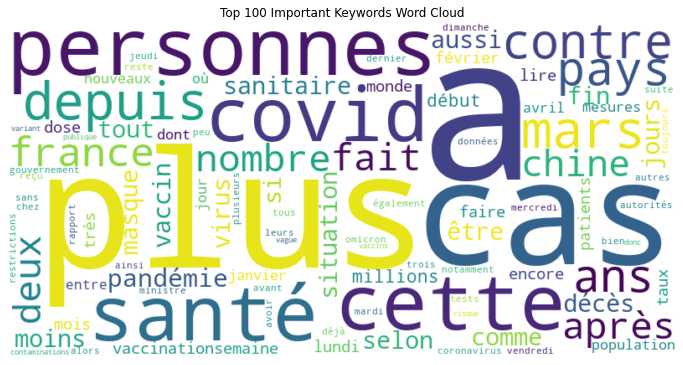

In [24]:
""" from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(word_counts, title, n_keywords=100):
    top_n_keywords = dict(sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:n_keywords])

    plt.figure(figsize=(12, 8))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_n_keywords)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Plot the word cloud for the top 100 important keywords
plot_word_cloud(important_keywords, "Top 100 Important Keywords Word Cloud", n_keywords=100)
 """

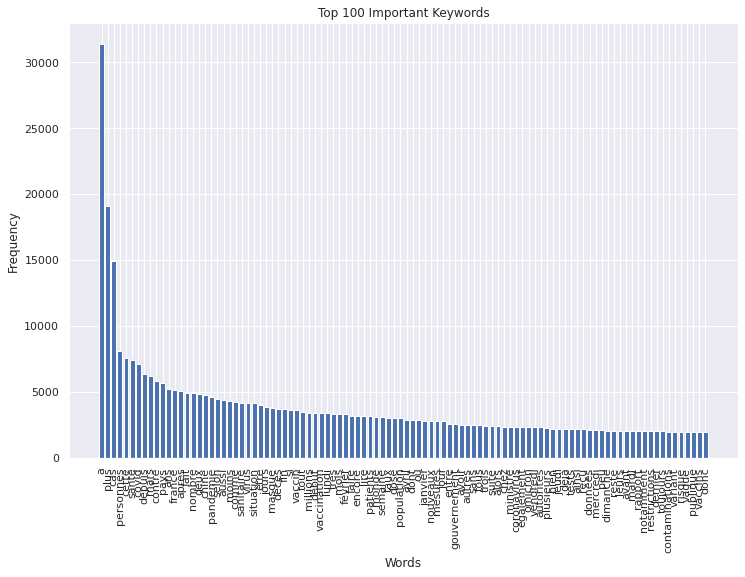

In [28]:
""" def plot_word_frequencies(word_counts, title, n_keywords=100):
    sns.set(style="darkgrid")
    plt.figure(figsize=(12, 8))

    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:n_keywords]
    words, counts = zip(*sorted_word_counts)

    plt.bar(words, counts)
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Plot the bar chart for the top 100 important keywords
plot_word_frequencies(important_keywords, "Top 100 Important Keywords", n_keywords=100)
 """